In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import pickle

import matplotlib.cm as cm

from fastai import *
from fastai.text import *

from pathlib import Path

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, hamming_loss, zero_one_loss, accuracy_score

In [3]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [11]:
!python -m fastai.utils.show_install



```text
=== Software === 
python        : 3.7.4
fastai        : 1.0.57
fastprogress  : 0.1.21
torch         : 1.0.1.post2
nvidia driver : 410.72
torch cuda    : 10.0.130 / is available
torch cudnn   : 7402 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 7611MB | Tesla P4

=== Environment === 
platform      : Linux-4.9.0-8-amd64-x86_64-with-debian-9.8
distro        : #1 SMP Debian 4.9.130-2 (2018-10-27)
conda env     : base
python        : /opt/anaconda3/bin/python
sys.path      : /home/jupyter/kneedle-exploration
/opt/anaconda3/lib/python37.zip
/opt/anaconda3/lib/python3.7
/opt/anaconda3/lib/python3.7/lib-dynload
/opt/anaconda3/lib/python3.7/site-packages
/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once

In [13]:
bs=32

## Loading Data

In [4]:
path = "./data/clean/"

In [5]:
df = pd.read_csv(f'{path}/train.csv')

In [6]:
df

,label,text,is_valid
0,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
1,SECRETARIA DE ESTADO DE CULTURA,PROCESSO: 00150-00010629/2018-72; NOTA DE EMPE...,False
2,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
3,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO,...",A Comissão Permanente de Licitação do BRB - BA...,False
4,CASA CIVIL,A ADMINISTRADORA REGIONAL DE TAGUATINGA DO DIS...,False
...,...,...,...
712,SECRETARIA DE ESTADO DE OBRAS E INFRAESTRUTURA,O Pregoeiro da CAESB no uso de suas atribuiçõe...,True
713,SECRETARIA DE ESTADO DE DESENVOLVIMENTO ECONÔMICO,"O SUBSECRETÁRIO DE ADMINISTRAÇÃO GERAL, DA SEC...",True
714,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR DO DEPARTAMENTO DE GESTÃO DE PESSOAS...,True
715,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,PROCESSO: 00054-00027353/2018-03. PARTES: DF/P...,True


In [7]:
df_train = df[df["is_valid"] == False]; df_train

,label,text,is_valid
0,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
1,SECRETARIA DE ESTADO DE CULTURA,PROCESSO: 00150-00010629/2018-72; NOTA DE EMPE...,False
2,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
3,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO,...",A Comissão Permanente de Licitação do BRB - BA...,False
4,CASA CIVIL,A ADMINISTRADORA REGIONAL DE TAGUATINGA DO DIS...,False
...,...,...,...
475,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO,...",A DIRETORA PRESIDENTE DO INSTITUTO DE PREVIDÊN...,False
476,SECRETARIA DE ESTADO DE SAÚDE,A DIRETORA DO HOSPITAL MATERNO INFANTIL DE BRA...,False
477,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
478,"SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIM...","O SUBSECRETÁRIO DE ADMINISTRAÇÃO GERAL, DA SEC...",False


In [8]:
df_lm = pd.read_csv(f'{path}/unsup/unsup.csv'); df_lm

,text
0,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...
1,A Comissão Permanente de Licitação da BRB ADMI...
2,PROCESSO Nº 00095-00002392/2018-12.\nO DIRETOR...
3,Partes: DETRAN-DF e a empresa SINASC SINALIZAÇ...
4,Espécie: Contrato nº 647/2018-CEB DISTRIBUIÇÃO...
...,...
1921,O Secretário de Estado de Cultura do Distrito ...
1922,PROCESSO Nº 00150-00010640/2018-32\nCLÁUSULA P...
1923,Processo: 00220-00005431/2018-32 - Das Partes:...
1924,Processo: PROCESSO 00220-00005706/2018-38. Par...


In [21]:
data_lm = (TextList.from_df(df_lm,cols='text', processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
                           .split_by_rand_pct(0.2, seed=seed)
                           .label_for_lm()
                           .databunch(bs=bs))

In [22]:
data_lm.save('data/data_lm_export.pkl')

In [23]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [9]:
perplexity = Perplexity()
f1 = FBeta(beta=1, average="weighted")

In [10]:
lm_fns3 = ['pt_wt_sp15_multifit', 'pt_wt_vocab_sp15_multifit']
lm_fns3_bwd = ['pt_wt_sp15_multifit_bwd', 'pt_wt_vocab_sp15_multifit_bwd']

## Fine-tune forward LM

In [39]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained_fnames=lm_fns3, drop_mult=1., 
                                  metrics=[error_rate, accuracy, perplexity])

In [30]:
learn_lm.predict("O Governador", n_words=15)

'O Governador ▁é ▁um ▁xxmaj ▁distrito ▁localizado ▁em ▁xxmaj ▁ca ja d ja ra , ▁no ▁estado'

In [32]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


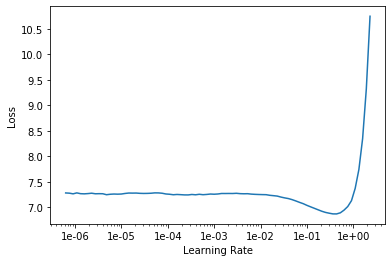

In [34]:
learn_lm.recorder.plot()

In [35]:
lr = 1e-1

In [40]:
learn_lm.fit_one_cycle(2, lr, wd=0.1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,7.481511,5.373352,0.885714,0.114286,215.584198,00:31
1,5.048022,3.441658,0.628571,0.371429,31.238693,00:31


In [43]:
learn_lm.save('fine_tune_lm')
learn_lm.save_encoder('fine_tune_enc')

In [45]:
learn_lm.unfreeze()
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


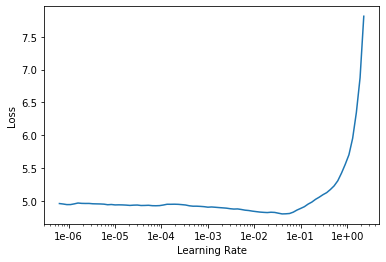

In [47]:
learn_lm.recorder.plot()

In [50]:
lr = 1e-2

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.856463,1.908529,0.428571,0.571429,6.743164,00:44
1,2.789543,0.886697,0.285714,0.714286,2.427099,00:45
2,2.446919,0.571255,0.185714,0.814286,1.770488,00:45
3,2.103412,0.380291,0.142857,0.857143,1.462710,00:45
4,2.071517,0.292240,0.100000,0.900000,1.339425,00:45
5,1.958919,0.221226,0.071429,0.928571,1.247605,00:45
6,1.790144,0.197682,0.057143,0.942857,1.218575,00:45
7,1.622401,0.141947,0.042857,0.957143,1.152516,00:45
8,1.474178,0.135097,0.028571,0.971429,1.144647,00:45
9,1.345698,0.137709,0.028571,0.971429,1.147642,00:45


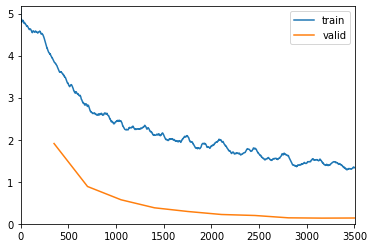

In [52]:
learn_lm.fit_one_cycle(10, lr, wd=0.1, moms=(0.8,0.7), callbacks=[ShowGraph(learn_lm)])

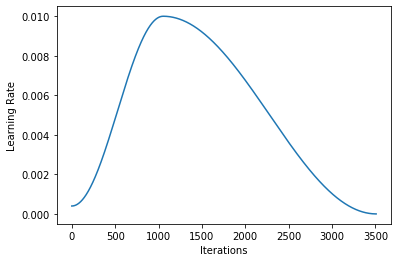

In [53]:
learn_lm.recorder.plot_lr()

In [57]:
learn_lm.predict("O Governador", n_words=30)

'O Governador ▁68 ▁da ▁xxmaj ▁companhia ▁de ▁xxmaj ▁desenvolvimento ▁xxmaj ▁habitacional ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁2. ▁xxmaj bitschek ▁os ▁conhecimento s ▁de ▁valores ▁do ▁xxmaj ▁contrato ▁no . ▁002 ▁/'

In [54]:
learn_lm.save('fine_tune_lm')
learn_lm.save_encoder('fine_tune_enc')

## Fine-tune backward LM

In [58]:
data_lm = (TextList.from_df(df_lm,cols='text', processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
                           .split_by_rand_pct(0.2, seed=seed)
                           .label_for_lm()
                           .databunch(bs=bs, backwards=True))

In [59]:
data_lm.show_batch()

idx,text
0,"▁do ▁termos ▁nos , comprasnet ▁ ▁do ▁sítio ▁no ada ▁process ▁será ▁pública ▁xxmaj ▁sessão ▁xxmaj ▁a ). 3 ▁97400 : uasg ▁( ▁xxup br . gov . comprasnet . ww ▁w ▁e br . gov . df . tc . ww ▁w : ▁sítios ▁pelos ▁ou 742 ▁3314-2 61) ▁( ▁telefone , ▁tcdf ▁xxup ▁do ▁anexo ▁xxmaj . ▁ed ▁xxmaj ▁do ▁andar ▁xxmaj o ▁2 ▁no ▁localizado , ▁licitação"
1,"s ▁regra ▁as ▁e ▁pertinente ▁legislação ▁a ▁com sonância ▁con ▁em ▁mencionadas ▁acima ▁disposições ▁das ância ▁observ ▁fiel ▁da os ▁incumbid ▁servidores ▁mencionados ▁os ▁ficam ▁xxmaj o ▁2 . ▁art ▁xxmaj . financeira - ▁administrativo ▁atividades ▁xxmaj ▁das ▁coordenação ▁xxmaj ▁na ém b ▁tam á ▁atuar ▁fiscalização ▁na ▁atuar ▁de ém ▁al ▁lopes ▁xxmaj s ▁marti ▁xxmaj ▁rodrigues ▁xxmaj ▁paiva ▁xxmaj ▁de ▁thais ▁xxmaj ▁servidora ▁a ▁que ▁sendo , ▁83.359-2"
2,", ▁03 - ▁cnp ▁xxup ▁símbolo ▁xxmaj , ▁política ▁xxmaj ▁natureza ▁xxmaj ▁de ▁cargo ▁xxmaj ▁do , ▁silva ▁xxup ▁da ▁xxup ▁martins ▁xxup ileu rg ▁a ▁xxup , ▁pedido ▁a , ▁exonerar ▁xxup . ▁federal ▁distrito ▁xxmaj ▁do ▁comunicação ▁xxmaj ▁de ▁estado ▁xxmaj ▁de ▁secretaria ▁xxmaj ▁da , ▁estado ▁xxmaj ▁de ▁secretário ▁xxmaj ▁de , -03 ▁cnp ▁xxup ▁símbolo ▁xxmaj , ▁política ▁xxmaj ▁natureza ▁xxmaj ▁de ▁cargo ▁xxmaj ▁do ,"
3,"i ▁fil ▁xxup 31, 71 ▁19713 ; ▁moura ▁xxup ▁moreira ▁xxup ▁borges ▁xxup pe i ▁fil ▁xxup 74, 74 ▁19712 ; la ndo ▁espi ▁xxup da e bi ▁ ▁xxup pe i ▁fil ▁xxup 75, 26 10 ▁197 ; cao ▁concei ▁xxup ▁da ▁xxup ▁barbosa ▁xxup pe i ▁fil ▁xxup 83, 11 ▁19712 ; ▁fernandes ▁xxup ▁alencar ▁xxup pe i ▁fil ▁xxup 104, 0 ▁19713 ; ▁cardoso ▁xxup ▁ribeiro ▁xxup"
4,"▁xxmaj ▁de ▁comissão ▁xxmaj stituírem ▁con , ▁primeiro ▁do ▁presidência ▁a ▁sob , ▁para -4; 45 ▁215.7 ▁no ▁matrícula , ▁ambiente ▁xxmaj ▁meio ▁xxmaj ▁do ▁atividades ▁xxmaj ▁de ▁analista ▁xxmaj , ▁mesquita ▁xxup ▁de ▁xxup ▁gonçalves ▁xxup o ▁fábi ▁xxup ▁luis ▁xxup ▁e ; x .259- 4 ▁26 ▁xxup ▁no ▁matrícula , ▁urbanas ▁xxmaj ▁atividades ▁xxmaj ▁de ▁fiscal ▁xxmaj ▁auditora ▁xxmaj , ▁mendes ▁xxup ▁moraes ▁xxup ▁de ▁xxup a ▁flávi"


In [61]:
data_lm.save('./data/data_lm_back.pkl')

In [62]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained_fnames=lm_fns3_bwd, drop_mult=1., 
                                  metrics=[error_rate, accuracy, perplexity])

In [63]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


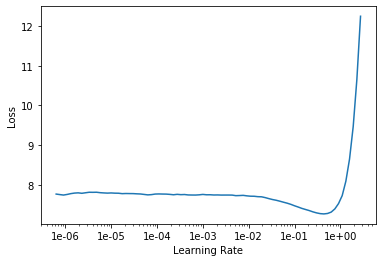

In [64]:
learn_lm.recorder.plot()

In [65]:
lr=1e-1

In [66]:
learn_lm.fit_one_cycle(2, lr, wd=0.1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,10.990519,6.884626,0.884405,0.115595,977.134705,00:34
1,5.945786,5.742748,0.852411,0.147589,311.920319,00:34


In [67]:
learn_lm.save('fine_tune_lm_bwd')
learn_lm.save_encoder('fine_tune_enc_bwd')

In [68]:
learn_lm.unfreeze()
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


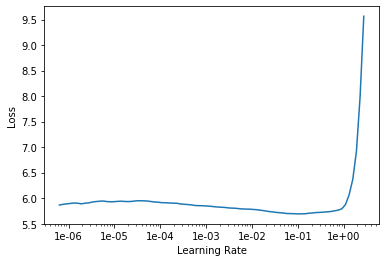

In [69]:
learn_lm.recorder.plot()

In [71]:
lr=1e-2

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,4.969108,5.090241,0.739782,0.260218,162.429001,00:46
1,3.325303,3.517292,0.559846,0.440154,33.693081,00:48
2,2.638740,2.938928,0.493934,0.506066,18.895563,00:49
3,2.240378,2.697034,0.463016,0.536984,14.835663,00:49
4,2.018229,2.563291,0.440516,0.559484,12.978454,00:49
5,1.991729,2.457468,0.422862,0.577138,11.675207,00:49
6,1.720751,2.354959,0.408532,0.591468,10.537695,00:49
7,1.680750,2.272086,0.393924,0.606076,9.699610,00:49
8,1.505812,2.230554,0.384866,0.615134,9.305024,00:49
9,1.318625,2.226812,0.383393,0.616607,9.270267,00:49


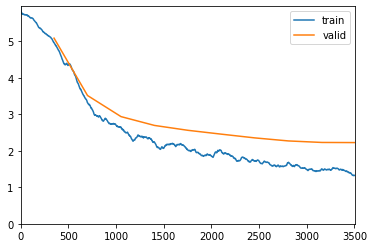

In [77]:
learn_lm.fit_one_cycle(10, lr, wd=0.1, moms=(0.8,0.7), callbacks=[ShowGraph(learn_lm)])

In [78]:
learn_lm.save('fine_tune_lm_bwd')
learn_lm.save_encoder('fine_tune_enc_bwd')

## Train forward classifier

In [11]:
bs=8

In [12]:
data_lm = load_data("data/", "data_lm_export.pkl", bs=bs)

In [13]:
data_clas = (TextList.from_df(df_train, vocab=data_lm.vocab, cols='text',
                              processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
                         .split_by_rand_pct(0.2, seed=seed)
                         .label_from_df(cols=0)
                         .databunch(bs=bs))

In [14]:
data_clas.vocab = data_lm.vocab

In [15]:
data_clas.save('data/data_clas_export.pkl')

In [16]:
data_clas.show_batch()

text,target
"▁xxbos ▁ o ▁xxup ▁subsecretário ▁xxup ▁de ▁xxup ▁administração ▁xxup ▁geral , ▁xxup ▁da ▁xxup ▁secretaria ▁xxup ▁de ▁xxup ▁estado ▁xxup ▁de ▁xxup ▁se g ura n ▁xxup ▁ ç a ▁xxup ▁pública ▁xxup ▁do ▁xxup ▁distrit o ▁xxup ▁federal , ▁no ▁uso ▁de ▁sua s ▁atribuições ▁prevista s ▁no ▁art . ▁30 ▁do ▁xxmaj ▁decreto ▁32.598 ▁/ ▁2010, ▁e ▁vis ando ▁a ▁instrução ▁dos ▁autos ▁do ▁xxmaj ▁processo ▁no",SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA
"▁xxbos ▁ o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrit o ▁xxup ▁federal , ▁no ▁uso ▁de ▁sua s ▁atribuições ▁legais , ▁e s - ▁ pe cial mente ▁as ▁prevista s ▁no ▁art . ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrit o ▁xxmaj ▁federal , ▁xxup ▁resolve : ▁xxup ▁exonerar , ▁por ▁estar ▁sendo ▁nome ada ▁para ▁outro ▁cargo , ▁xxup",PODER EXECUTIVO
"▁xxbos ▁ o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrit o ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere ▁ o ▁artigo ▁100, ▁incisos ▁xxup ▁iii , ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrit o ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁nomear ▁xxup ▁ s ever ino ▁xxup ▁de ▁xxup ▁sousa ▁xxup ▁oliveira ▁para ▁exercer ▁ o ▁xxmaj ▁cargo ▁de ▁xxmaj ▁natureza",PODER EXECUTIVO
"▁xxbos ▁ o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrit o ▁xxup ▁federal , ▁no ▁uso ▁de ▁sua s ▁atribuições ▁legais , ▁especial mente ▁as ▁prevista s ▁no ▁art . ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrit o ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁exonerar , ▁por ▁ter ▁sid o ▁nome ada ▁para ▁outro ▁cargo , ▁xxup ▁ iva ni se ▁xxup",PODER EXECUTIVO
"▁xxbos ▁ o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrit o ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere ▁ o ▁artigo ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrit o ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁nomear ▁xxup ▁cami la ▁xxup ▁be a t riz ▁xxup ▁da ▁xxup ▁silva ▁xxup ▁oliveira ▁para ▁exercer ▁ o ▁xxmaj ▁cargo ▁de ▁xxmaj ▁natureza",PODER EXECUTIVO


In [17]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [18]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.3, 
                                  metrics=[accuracy,f1])
learn_c.load_encoder("fine_tune_enc")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (384 items)
x: TextList
▁xxbos ▁xxup ▁processo : ▁00150-0001062 9 ▁/ ▁2018- 72 ; ▁xxup ▁nota ▁xxup ▁de ▁xxup ▁empenho ▁xxmaj ▁no ▁0110 0 ▁/ ▁2018; ▁xxup ▁das ▁xxup ▁partes : ▁xxup ▁df ▁/ ▁xxup ▁sec ▁/ ▁xxup ▁fac ▁x ▁xxup ▁santiago ▁xxup ▁machado ▁xxup ▁de lla pe . ▁xxmaj ▁na ▁qual idade ▁de ▁xxmaj ▁beneficiário ▁/ ▁a . ▁xxup ▁espécie : ▁xxmaj ▁termo ▁de ▁xxmaj ▁ajuste ▁xxmaj ▁no ▁7 06 ▁/ ▁2018; ▁xxup ▁modalidade : ▁xxmaj ▁seleção ▁xxmaj ▁pública ; ▁xxup ▁do ▁xxup ▁objeto : ▁ o ▁presente ▁xxmaj ▁termo ▁de ▁xxmaj ▁ajuste ▁tem ▁por ▁objeto ▁a ▁concessão ▁de ▁apoio ▁financeiro ▁pelo ▁xxup ▁fundo ▁xxup ▁de ▁xxup ▁apoio ▁à ▁xxup ▁cultura ▁ao ▁xxmaj ▁programa ▁xxmaj ▁conexão ▁xxmaj ▁cultural ▁xxup ▁df ▁ # ▁xxmaj ▁negócios ▁de ▁interesse ▁do ▁/ ▁a ▁xxmaj ▁beneficiário ▁/ ▁a ▁acima ▁especificado ▁/ ▁a ; ▁xxup ▁do ▁xxup ▁valor : ▁xxup ▁ r $ ▁15.000,00 ▁( quinze ▁mil ▁reais ) ▁que ▁ser á ▁liberado ▁em ▁parcela ▁única ▁e ▁transferido s ▁à ▁conta

In [19]:
learn_c.freeze()
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


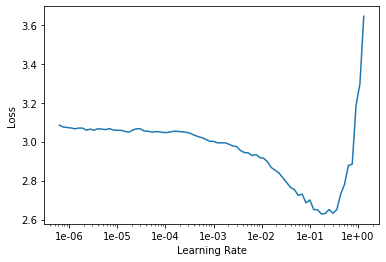

In [20]:
learn_c.recorder.plot()

In [21]:
lr=3e-2

In [22]:
learn_c.fit_one_cycle(4, lr, wd=0.1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.331916,2.107567,0.437500,0.410825,00:08
1,1.729283,1.561135,0.552083,0.478157,00:08
2,1.260132,1.433524,0.666667,0.657327,00:08
3,0.824202,1.256387,0.708333,0.694376,00:08


In [23]:
learn_c.save("clf_fwd")

In [29]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), wd=0.1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.274042,1.336352,0.625000,0.588598,00:09
1,0.922084,1.164855,0.677083,0.665012,00:09


In [30]:
learn_c.save("clf_fwd")

In [31]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(4, slice(lr/2/(2.6**4),lr/2), wd=0.1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.484988,1.017535,0.750000,0.727987,00:11
1,0.503630,1.405647,0.687500,0.669772,00:11
2,0.362882,0.974657,0.812500,0.810085,00:11
3,0.188672,0.920892,0.802083,0.800939,00:11


In [32]:
learn_c.save("clf_fwd")

In [35]:
learn_c.unfreeze()
learn_c.fit_one_cycle(3, slice(lr/10/(2.6**4),lr/10), wd=0.1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.077078,0.898982,0.791667,0.794413,00:15
1,0.056076,0.824895,0.843750,0.840283,00:15
2,0.043937,0.829387,0.843750,0.839421,00:15


In [37]:
learn_c.save("clf_fwd")

## Evaluate Forward CLF

/opt/anaconda3/lib/python3.7/site-packages/fastai/train.py:200: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


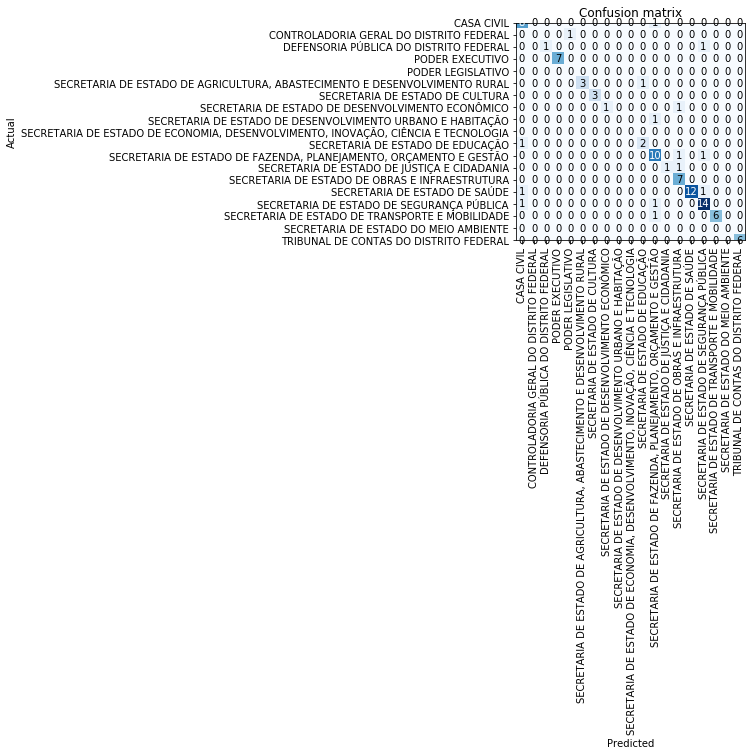